#CNN/LSTM model

In [1]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

Dowload data

In [68]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)

#save Close price and Log Returns into a pd.Series
Close_price = sp500_data['Close'].copy().astype(float)
Log_return = sp500_data['Log Return'].copy().astype(float)

#drop columns not needed
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)

#import ARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/close_price_residuals.csv', index_col=0)
sp500_data.insert(0, 'Residuals', residuals.values)

#import ARIMA fitted values (predictions on the training set)
fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/fitted_values.csv', index_col=0)

#import ARIMA predictions on the test set
ARIMA_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv', index_col=0).squeeze() #to read it as a pd.Series
ARIMA_predictions.index = pd.to_datetime(ARIMA_predictions.index)

Mounted at /content/gdrive


##Helper functions to move data to the GPU

In [28]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Feature Engineering (multivariate sliding windows)

In [4]:
#time features
sp500_data['Year'] = sp500_data.index.year #this will be treated as a numerical feature

#those will be treated as categorical features
sp500_data['Month'] = sp500_data.index.month
sp500_data['Day'] = sp500_data.index.day
sp500_data['Day_of_week'] = sp500_data.index.dayofweek
sp500_data['Quarter'] = sp500_data.index.quarter
# sp500_data['Index_hash'] = sp500_data.index.map(lambda x: hash(x))


#lag features
for lag in (1,5,10,25,365):
  sp500_data[f'lag_{lag}'] = sp500_data['Residuals'].shift(lag)


#rolling features
for window in (5,10,25):
  sp500_data[f'rolling_mean_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).mean() #shift by one because the current close price won't be available at the day of the prediction
  sp500_data[f'rolling_std_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_Residuals_{window}'] = sp500_data['Residuals'].shift(1).rolling(window=window).skew()
  sp500_data[f'rolling_mean_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).mean()
  sp500_data[f'rolling_std_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).std()
  sp500_data[f'rolling_skew_volume_{window}'] = sp500_data['Volume'].shift(1).rolling(window=window).skew()


#substitute NaN values with 0
sp500_data.fillna(0, inplace=True)


#visualize
sp500_data.columns

Index(['Residuals', 'Volume', 'Year', 'Month', 'Day', 'Day_of_week', 'Quarter',
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25'],
      dtype='object')

Encode categorical features

In [5]:
#cyclical encoding to reflect the periodic nature of the categorical features (https://stackoverflow.com/questions/58936445/whats-the-proper-way-to-present-numerical-categorical-data-specifically-hour-o)
sp500_data['month_sin'] = np.sin(2 * np.pi * sp500_data['Month'] / 12)
sp500_data['month_cos'] = np.cos(2 * np.pi * sp500_data['Month'] / 12)

sp500_data['day_sin'] = np.sin(2 * np.pi * sp500_data['Day'] / 31)
sp500_data['day_cos'] = np.cos(2 * np.pi * sp500_data['Day'] / 31)

sp500_data['day_of_week_sin'] = np.sin(2 * np.pi * sp500_data['Day_of_week'] / 5)
sp500_data['day_of_week_cos'] = np.cos(2 * np.pi * sp500_data['Day_of_week'] / 5)

sp500_data['quarter_sin'] = np.sin(2 * np.pi * sp500_data['Quarter'] / 4)
sp500_data['quarter_cos'] = np.cos(2 * np.pi * sp500_data['Quarter'] / 4)


#numerical / categorical columns
num_cols = [
       'lag_1', 'lag_5', 'lag_10', 'lag_25', 'lag_365',
       'rolling_mean_Residuals_5', 'rolling_std_Residuals_5',
       'rolling_skew_Residuals_5', 'rolling_mean_volume_5',
       'rolling_std_volume_5', 'rolling_skew_volume_5',
       'rolling_mean_Residuals_10', 'rolling_std_Residuals_10',
       'rolling_skew_Residuals_10', 'rolling_mean_volume_10',
       'rolling_std_volume_10', 'rolling_skew_volume_10',
       'rolling_mean_Residuals_25', 'rolling_std_Residuals_25',
       'rolling_skew_Residuals_25', 'rolling_mean_volume_25',
       'rolling_std_volume_25', 'rolling_skew_volume_25']
cat_cols = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'day_of_week_sin', 'day_of_week_cos', 'quarter_sin', 'quarter_cos']


#drop columns not needed
sp500_data.drop(['Month', 'Day', 'Day_of_week', 'Volume', 'Quarter'], axis=1, inplace=True)


#visualise
sp500_data

,Residuals,Year,lag_1,lag_5,lag_10,lag_25,lag_365,rolling_mean_Residuals_5,rolling_std_Residuals_5,rolling_skew_Residuals_5,...,rolling_std_volume_25,rolling_skew_volume_25,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.306564,2000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,5.712682e-01,0.820763,0.000000,1.000000,1.000000e+00,6.123234e-17
2000-01-04,-56.446985,2000,-0.306564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,7.247928e-01,0.688967,0.951057,0.309017,1.000000e+00,6.123234e-17
2000-01-05,-60.496419,2000,-56.446985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,8.486443e-01,0.528964,0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-06,-59.933922,2000,-60.496419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.377521e-01,0.347305,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2000-01-07,-21.433871,2000,-59.933922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,5.000000e-01,0.866025,9.884683e-01,0.151428,-0.951057,0.309017,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31,288.792765,2024,315.280792,387.120069,493.011489,405.877631,-644.077896,396.591694,56.341513,-0.548087,...,1.195016e+09,1.474773,-2.449294e-16,1.000000,-2.449294e-16,1.000000,0.951057,0.309017,-2.449294e-16,1.000000e+00
2025-01-02,274.534470,2025,288.792765,451.913308,468.365536,422.735876,-643.699194,376.926234,74.657066,-0.133943,...,1.210424e+09,1.505368,5.000000e-01,0.866025,3.943559e-01,0.918958,-0.587785,-0.809017,1.000000e+00,6.123234e-17
2025-01-03,347.276415,2025,274.534470,448.285888,288.739844,455.823366,-626.490156,341.450466,72.220274,0.901211,...,1.167135e+09,1.789773,5.000000e-01,0.866025,5.712682e-01,0.820763,-0.951057,0.309017,1.000000e+00,6.123234e-17


###train val test split

In [6]:
#train / vall / test split
train_data = sp500_data.loc[: '2018']
val_data = sp500_data.loc['2019': '2021']
train_val_data = sp500_data.loc[: '2021']
test_data = sp500_data.loc['2022':]

Scale datasets

In [7]:
# Initialize scalers
train_scaler = StandardScaler()
train_val_scaler = StandardScaler()

# Fit scaler only to the train set (when predicting on the val set) and on the train + validation set (when predicting on the test set)
train_scaler.fit(train_data[num_cols])
train_val_scaler.fit(train_val_data[num_cols])

# Create a copy of the datasets
train_data_scaled = train_data.copy()
val_data_scaled = val_data.copy()
train_val_data_scaled = train_val_data.copy()
test_data_scaled = test_data.copy()

# Scale numerical features
train_data_scaled.loc[:, num_cols] = train_scaler.transform(train_data[num_cols])
val_data_scaled.loc[:, num_cols] = train_scaler.transform(val_data[num_cols])

# Scale numerical features for train+val set and test set
train_val_data_scaled.loc[:, num_cols] = train_val_scaler.transform(train_val_data[num_cols])
test_data_scaled.loc[:, num_cols] = train_val_scaler.transform(test_data[num_cols])


#scale target
train_target_scaler = MinMaxScaler(feature_range=(-1, 1))
train_val_target_scaler = MinMaxScaler(feature_range=(-1, 1))

train_data_scaled['Residuals'] = train_target_scaler.fit_transform(train_data['Residuals'].values.reshape(-1, 1))
val_data_scaled['Residuals'] = train_target_scaler.transform(val_data['Residuals'].values.reshape(-1, 1))

train_val_data_scaled['Residuals'] = train_val_target_scaler.fit_transform(train_val_data['Residuals'].values.reshape(-1, 1))
test_data_scaled['Residuals'] = train_val_target_scaler.transform(test_data['Residuals'].values.reshape(-1, 1))


#X, y split
X_train = np.array(train_data_scaled.drop(columns=['Residuals']))
y_train = np.array(train_data_scaled['Residuals'])
X_val = np.array(val_data_scaled.drop(columns=['Residuals']))
y_val = np.array(val_data_scaled['Residuals'])
X_train_val = np.array(train_val_data_scaled.drop(columns=['Residuals']))
y_train_val = np.array(train_val_data_scaled['Residuals'])
X_test = np.array(test_data_scaled.drop(columns=['Residuals']))
y_test = np.array(test_data_scaled['Residuals'])

In [8]:
y_train[0:10]

array([0.93781704, 0.88570949, 0.88195095, 0.88247304, 0.91820742,
       0.93533867, 0.91829915, 0.90812591, 0.92527256, 0.9414054 ])

Multivariate sliding windows

In [9]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length, 1:]
      _y = data.iloc[i + seq_length, 0]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 1)
X_val, y_val= sliding_windows(val_data_scaled, 1)
X_test, y_test = sliding_windows(test_data_scaled, 5)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 5)

Convert data into tensors

In [ ]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


#istance of the custom dataset class
train_df = Custom_df(X_train, y_train)
val_df = Custom_df(X_val, y_val)
train_val_df = Custom_df(X_train_val, y_train_val)
test_df = Custom_df(X_test, y_test)


#create dataloaders (to perform training/inference in batch)
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


#get device
device = get_device()


#move to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
train_val_loader = DeviceDataLoader(train_val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

##Univariate sliding windows

In [29]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2022']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)

extended_test_data = pd.concat([train_val_data.iloc[-10:, 0], test_data], axis=0)
extended_test_data.index = pd.concat([train_val_data.iloc[-10:, 0], test_data], axis=0).index

# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))
train_val_data_scaled = pd.DataFrame(scaler.fit_transform(train_val_data.values.reshape(-1, 1)))
test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1, 1)))
extended_test_data_scaled = pd.DataFrame(scaler.transform(extended_test_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data_scaled, 10)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)
X_test_extended, y_test_extended = sliding_windows(extended_test_data_scaled, 10)

Covert data into tensor

In [30]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


#istance of the custom dataset class
train_df = Custom_df(X_train, y_train)
val_df = Custom_df(X_val, y_val)
train_val_df = Custom_df(X_train_val, y_train_val)
test_df = Custom_df(X_test, y_test)
test_extended_df = Custom_df(X_test_extended, y_test_extended)


#create dataloaders (to perform training/inference in batch)
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_extended_loader = DataLoader(test_extended_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


#get device
device = get_device()


#move to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
train_val_loader = DeviceDataLoader(train_val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
test_extended_loader = DeviceDataLoader(test_extended_loader, device)

##Neural network models

LSTM followed by CNN

In [31]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

LSTM_CNN_model = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
LSTM_CNN_model.to(device) #move the istance to the device

LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

CNN + LSTM parallel architecture

In [32]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

parallelCNNLSTM_model = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
parallelCNNLSTM_model.to(device) #move the istance to the device

ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [33]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 3

LSTM_model = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
LSTM_model.to(device) #move the istance to the device

LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

CNN model

In [34]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

CNN_model = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
CNN_model.to(device) #move the istance to the device

CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

##Training

In [119]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    # best_val_loss = float('inf') #initialized to the largest possible value
    # no_improve_count = 0  # Count epochs with no improvement in validation loss

    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])

        # if result['val_loss'] < best_val_loss:
        #     best_val_loss = result['val_loss']
        #     print(f"best vall loss: {best_val_loss}")
        #     no_improve_count = 0  # Reset counter on improvement
        # else:
        #     print(f"No improvement , current val loss: {result['val_loss']} best loss: {best_val_loss}")
        #     no_improve_count += 1  # Increment counter if no improvement


        model.epoch_end(epoch, result) #print results
        history.append(result)

        # if no_improve_count >= 50:
        #     print(f"No improvement in validation loss for {no_improve_count} epochs. Stopping training.")
        #     break

    return history

Train a single NN

In [112]:
history = [evaluate(LSTM_CNN_model, test_loader)]

#train model
epochs = 200
max_lr = 0.001
grad_clip = None
weight_decay = 1e-5
opt_func = torch.optim.Adam
warmup_epochs = 10

start_time = time.time()
history += fit(epochs, max_lr, LSTM_CNN_model, train_val_loader, test_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

warmup phase
Epoch [0], last_lr: 0.00020, train_loss: 0.1463, val_loss: 0.4561
Epoch [1], last_lr: 0.00030, train_loss: 0.1433, val_loss: 0.4523
Epoch [2], last_lr: 0.00040, train_loss: 0.1440, val_loss: 0.4479
Epoch [3], last_lr: 0.00050, train_loss: 0.1377, val_loss: 0.2740
Epoch [4], last_lr: 0.00060, train_loss: 0.0703, val_loss: 0.3696
Epoch [5], last_lr: 0.00070, train_loss: 0.0826, val_loss: 0.2602
Epoch [6], last_lr: 0.00080, train_loss: 0.0707, val_loss: 0.3086
Epoch [7], last_lr: 0.00090, train_loss: 0.0561, val_loss: 0.3482
Epoch [8], last_lr: 0.00100, train_loss: 0.0789, val_loss: 0.0755
Epoch [9], last_lr: 0.00100, train_loss: 0.0273, val_loss: 0.0373
annealing phase
Epoch [10], last_lr: 0.00100, train_loss: 0.0340, val_loss: 0.2209
Epoch [11], last_lr: 0.00100, train_loss: 0.0567, val_loss: 0.2645
Epoch [12], last_lr: 0.00100, train_loss: 0.0489, val_loss: 0.2092
Epoch [13], last_lr: 0.00100, train_loss: 0.0475, val_loss: 0.0903
Epoch [14], last_lr: 0.00100, train_loss: 0

Exception in thread Thread-43 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3

KeyboardInterrupt: 

Train all the NN models at once

In [120]:
import time
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for model in models:
    print(f"training model: {model}")
    #evaluate untrained model
    history = [evaluate(model, test_loader)]

    #train model
    epochs = 200
    max_lr = 0.001
    grad_clip = None
    weight_decay = 1e-5
    opt_func = torch.optim.Adam
    warmup_epochs = 10

    start_time = time.time()
    history += fit(epochs, max_lr, model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")

training model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
warmup phase
Epoch [0], last_lr: 0.00020, train_loss: 0.1486, val_loss: 0.4541
Epoch [1], last_lr: 0.00030, train_loss: 0.1433, val_loss: 0.4486
Epoch [2], last_lr: 0.00040, train_loss: 0.1336, val_loss: 0.2562
Epoch [3], last_lr: 0.00050, train_loss: 0.0557, val_loss: 0.2926
Epoch [4], last_lr: 0.00060, train_loss: 0.0723, val_loss: 0.1134
Epoch [5], last_lr: 0.00070, train_loss: 0.0387, val_loss: 0.0627
Epoch [6], last_lr: 0.00080, train_loss: 0.0284, val_loss: 0.2179
Epoch [7], last_lr: 0.00090, train_loss: 0.0708, val_loss: 0.3109
Epoch [8], last_lr: 0.00100, train_loss: 0.1192, val_loss: 0.1666
Epoch [9], last_lr: 0.00100, train_loss: 0.0527, val_loss

##Save models state dict

In [146]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istances

for model in models:
    model_name = model.__class__.__name__
    save_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

    #save state dict of the model
    torch.save(model.state_dict(), save_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load models

In [35]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

model_names = ['LSTM', 'CNN', 'ParallelCNN_LSTM', 'LSTM_CNN']
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces


for model_name, model_istance in zip(model_names, models):
    model_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

   #load state dict
    model_istance.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Mounted at /content/drive


<ipython-input-35-5d20d59d2c28>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_istance.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


##Batch inference

In [36]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


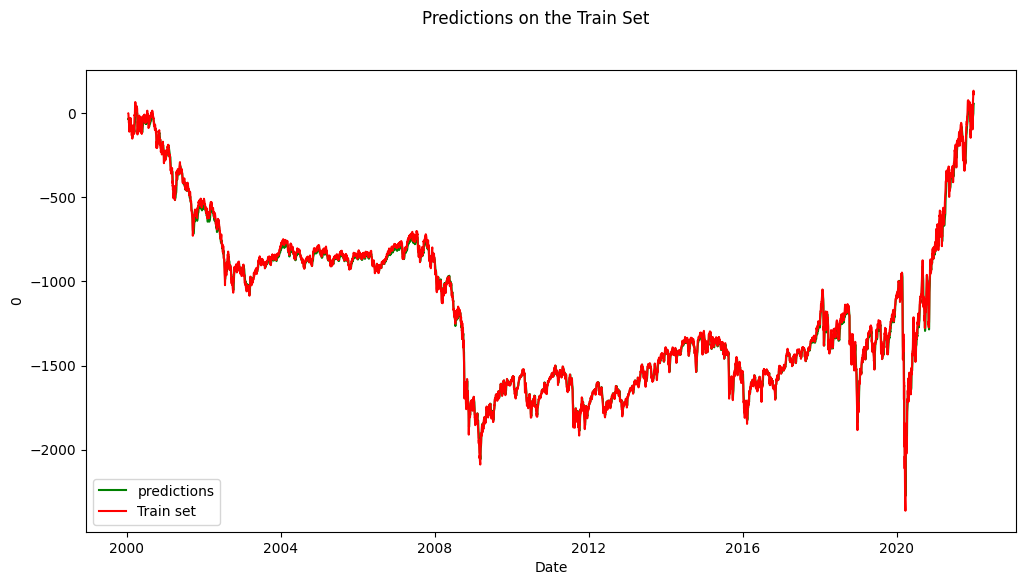

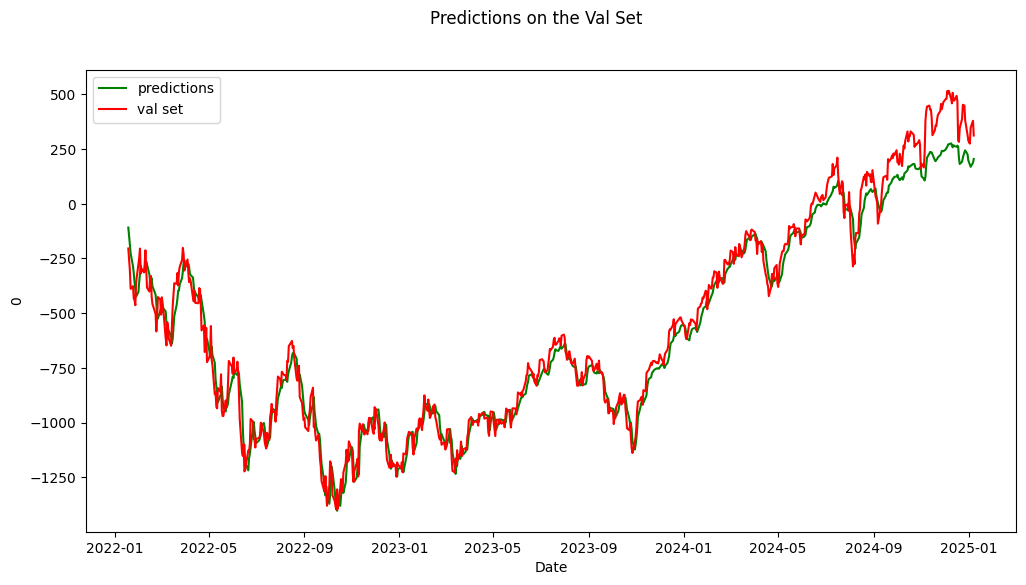

model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


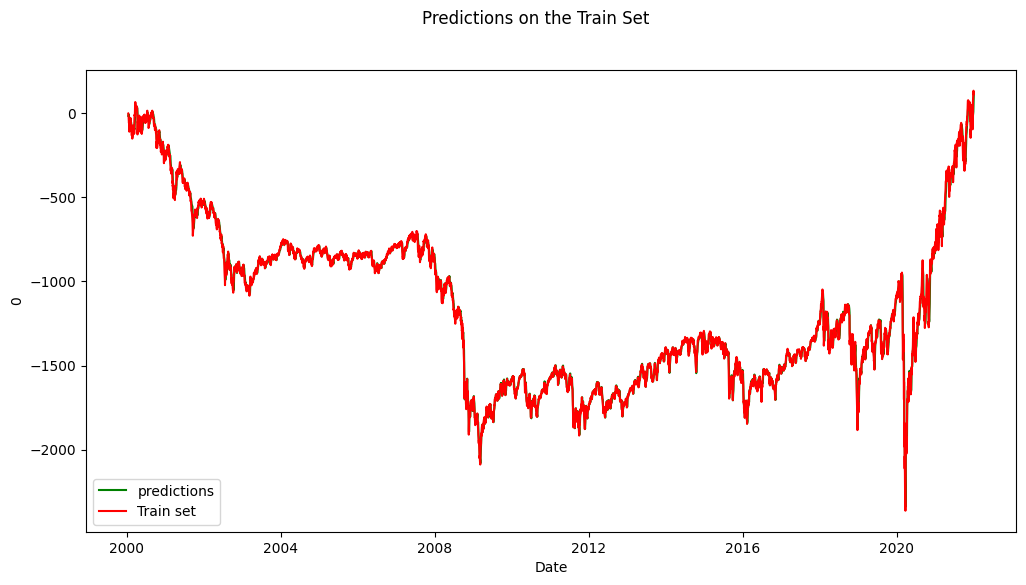

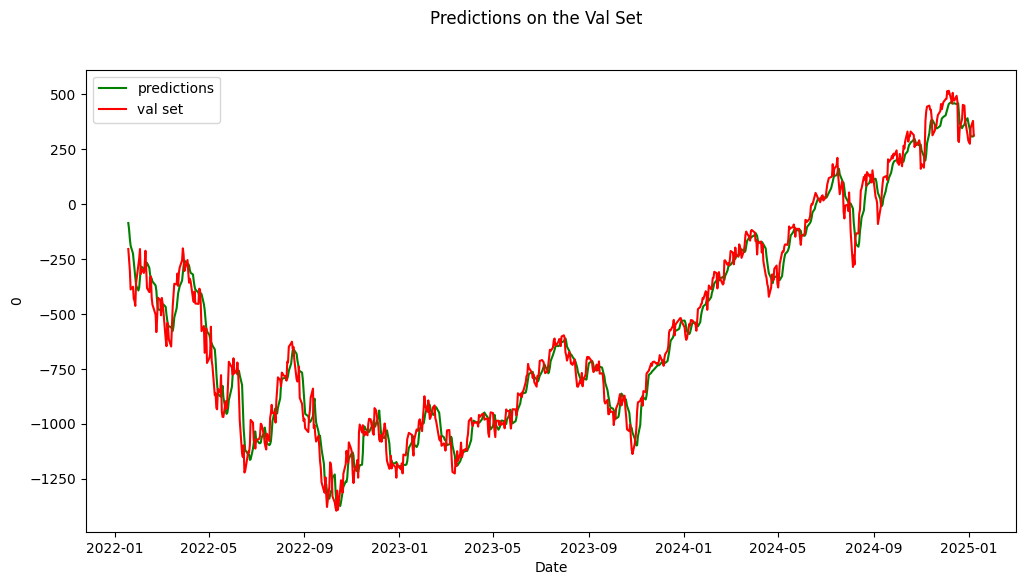

model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


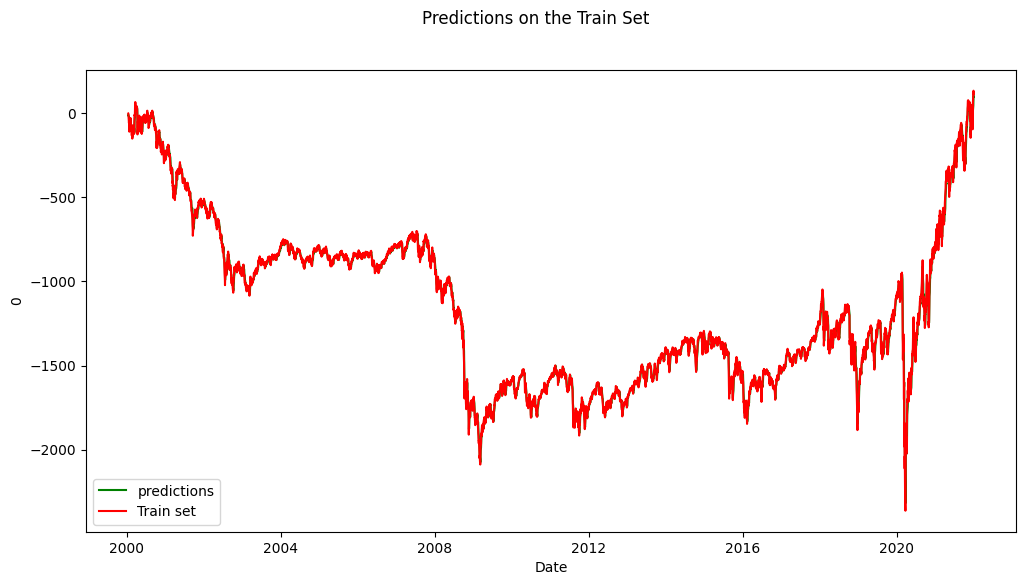

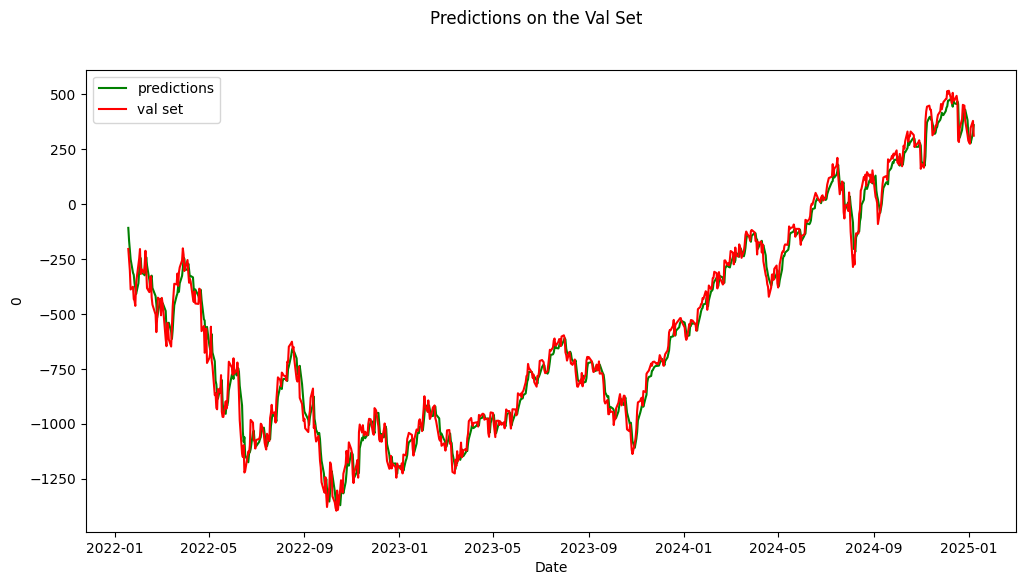

model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


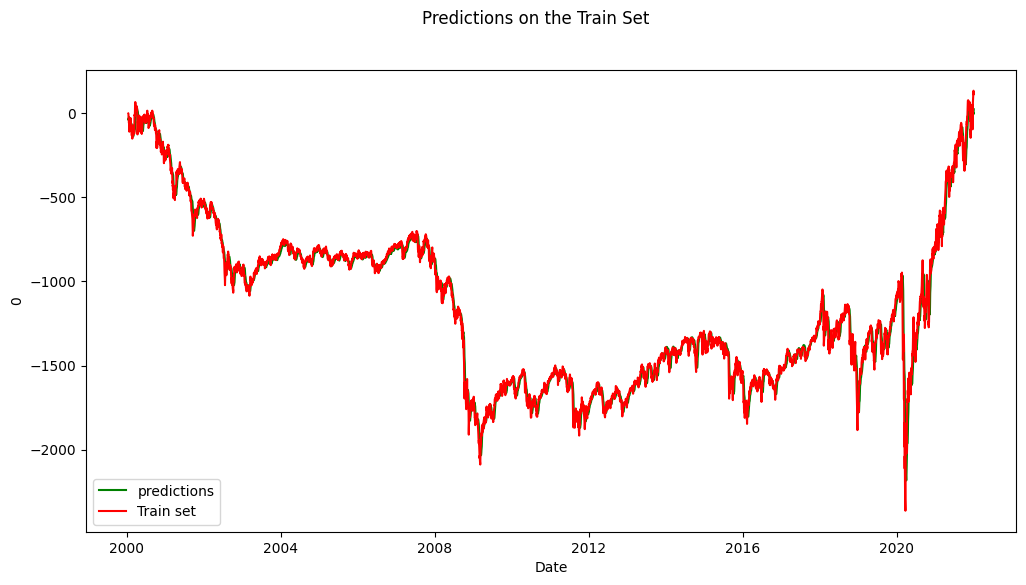

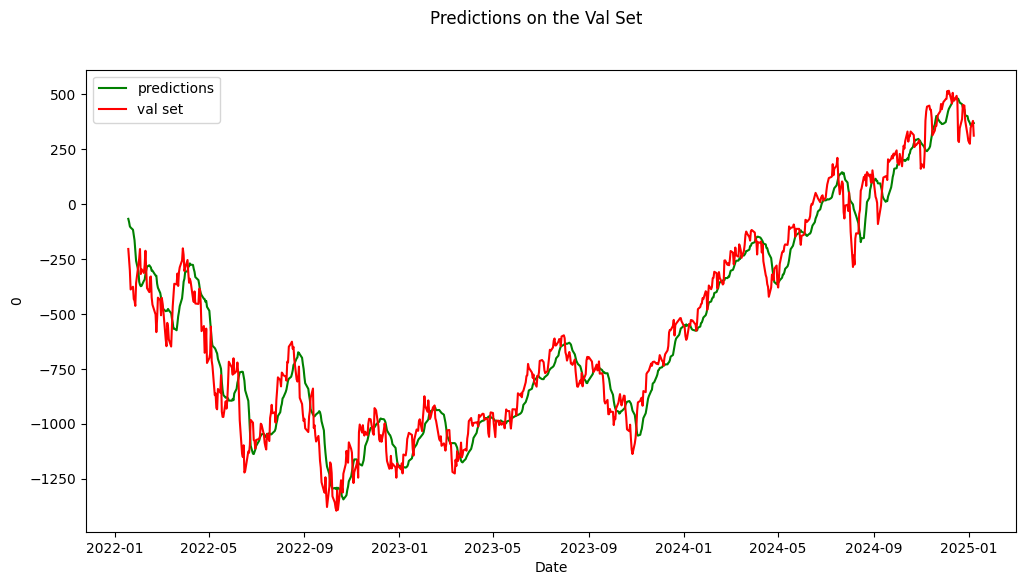

In [37]:
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]
for model in models:
    print(f"model: {model}")
    #batch inference
    prediction, actual = inference(model, test_loader)

    ## Inverse Scale
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(actual)


    #predictions on the test_loader
    prediction = pd.DataFrame(prediction)
    prediction.index = test_data[10:].index
    actual = pd.DataFrame(actual)
    actual.index = test_data[10:].index


    #predictions on the train_val_loader
    train_predictions, actual_train = inference(model, train_val_loader)

    ## Inverse Scale
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)

    train_predictions = pd.DataFrame(train_predictions)
    train_predictions.index = train_val_data[10:].index
    actual_train = pd.DataFrame(actual_train)
    actual_train.index = train_val_data[10:].index


    #visualize
    #predictions on the train set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions")
    sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train set")
    plt.suptitle('Predictions on the Train Set')
    plt.show()


    #predictions on the val set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions")
    sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "val set")
    plt.suptitle('Predictions on the Val Set')
    plt.show()


##Combine ARIMA and NN predictions

LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


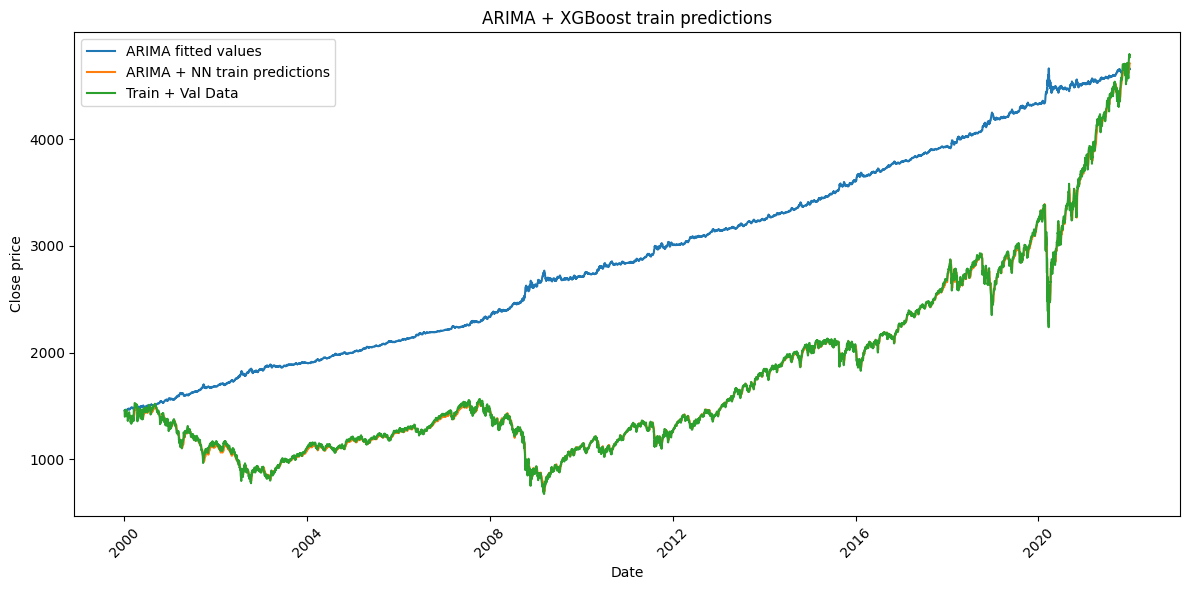

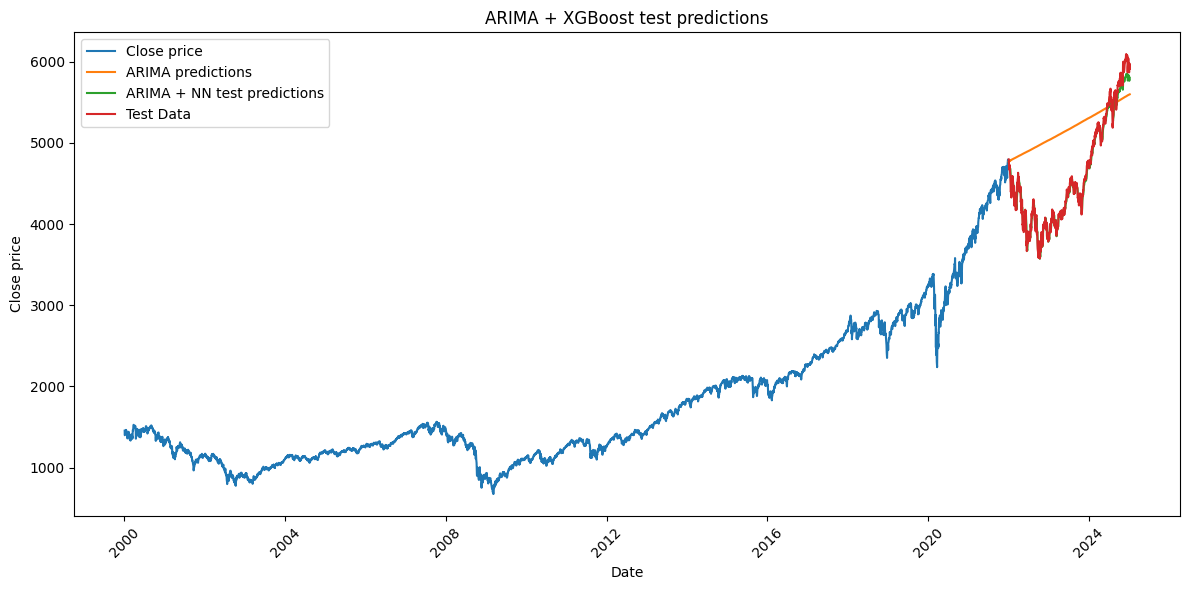

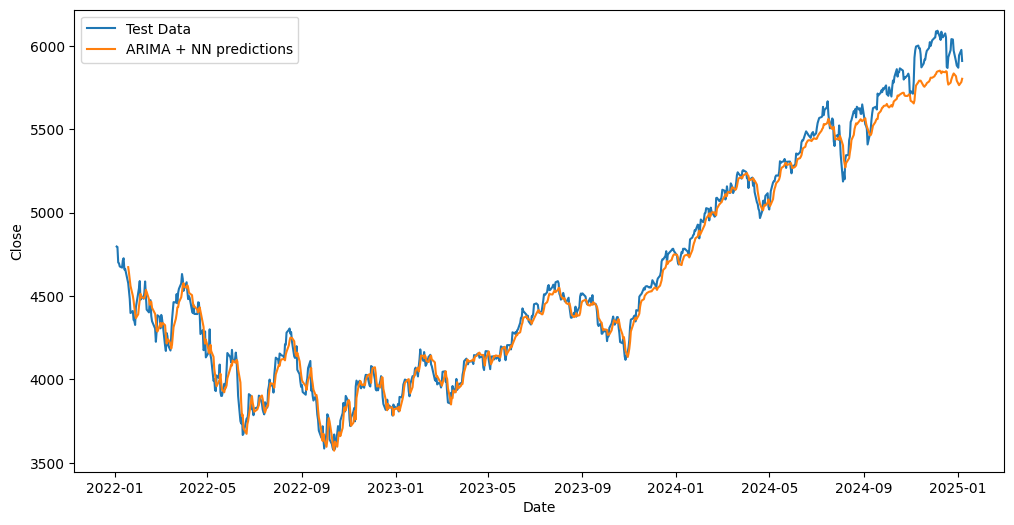

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


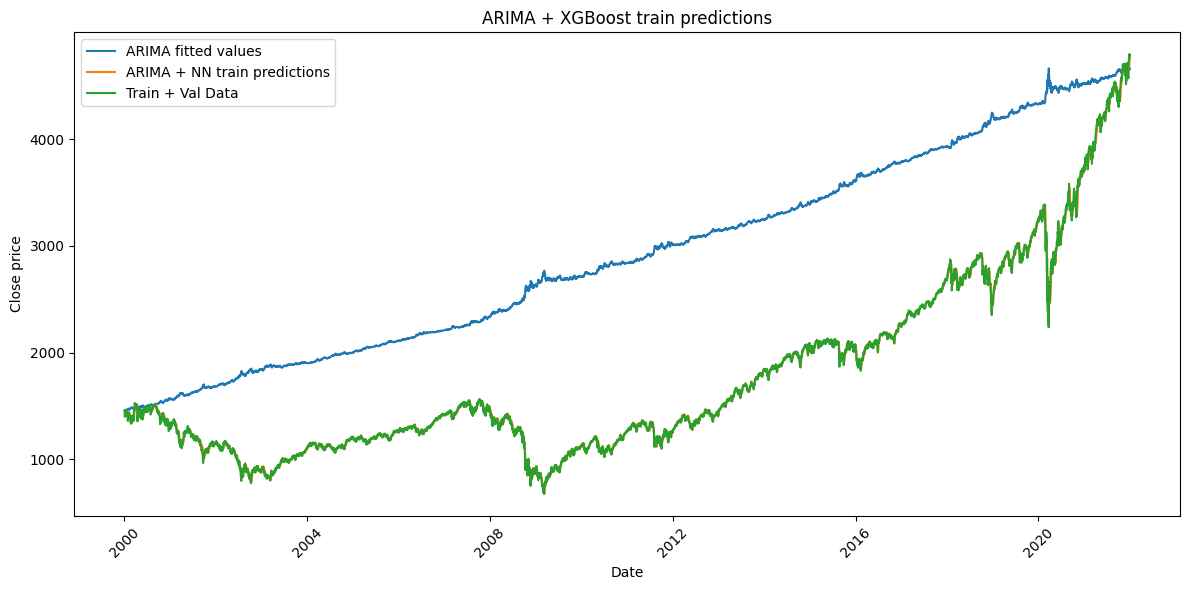

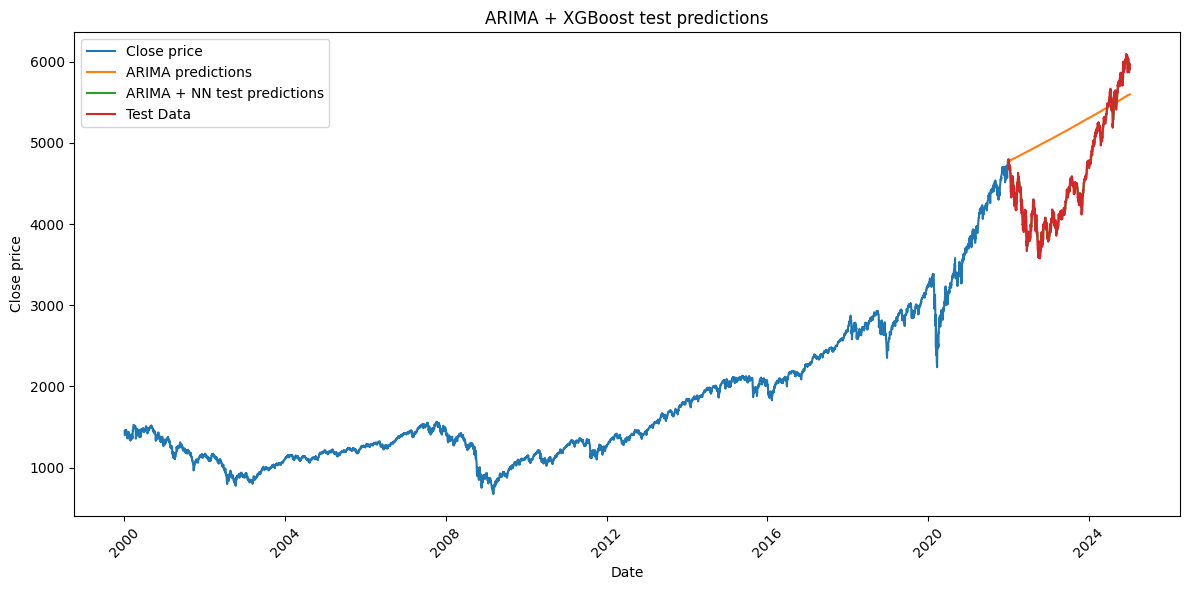

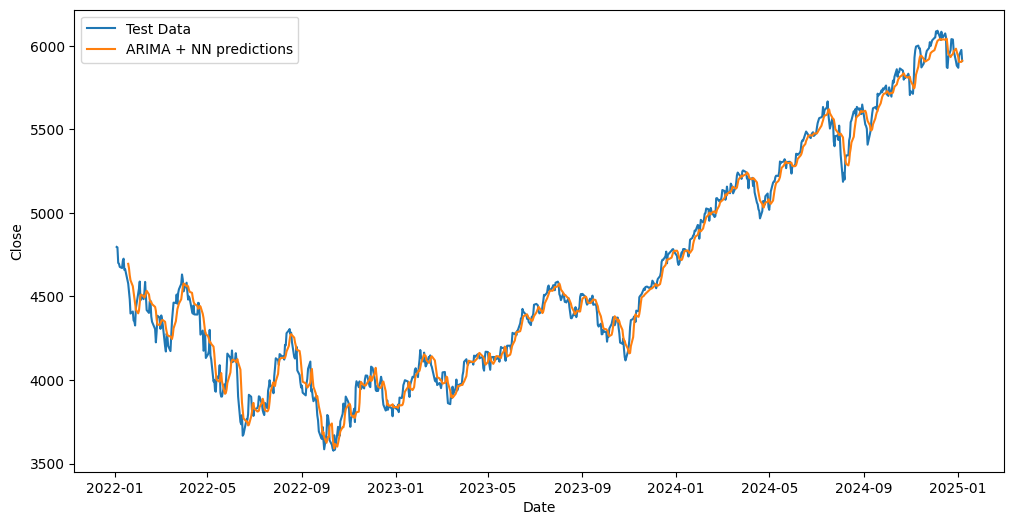

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


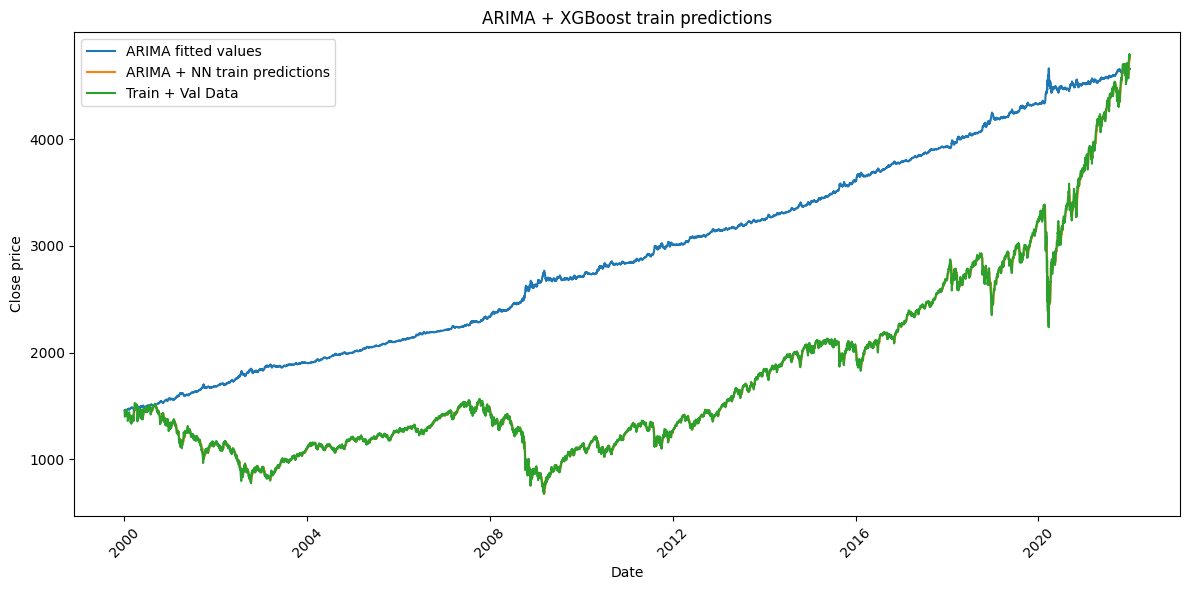

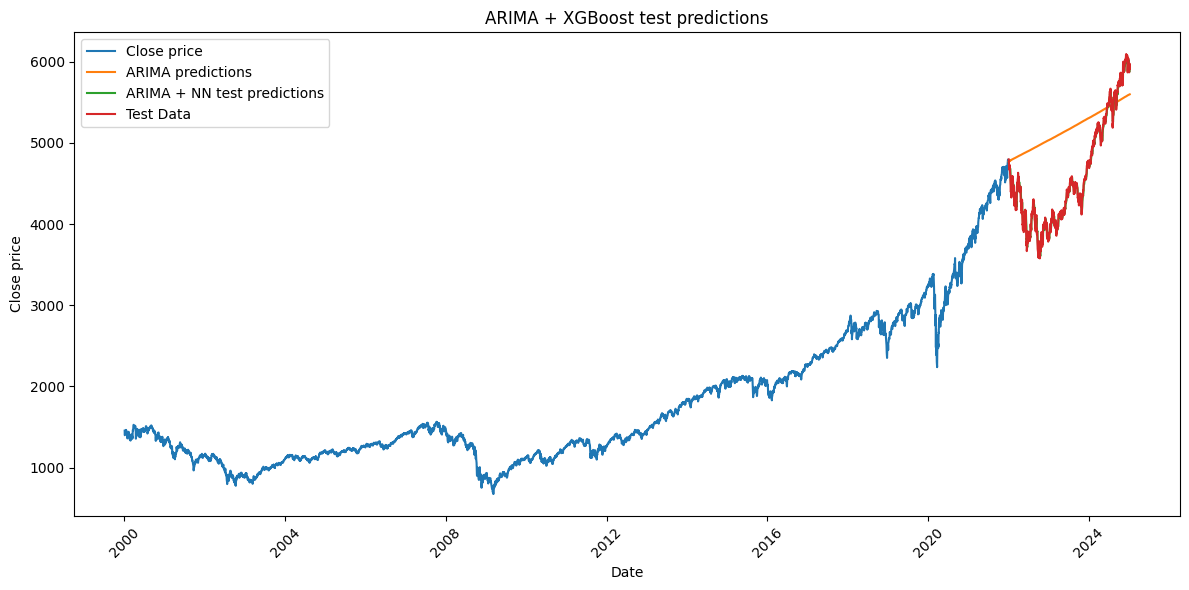

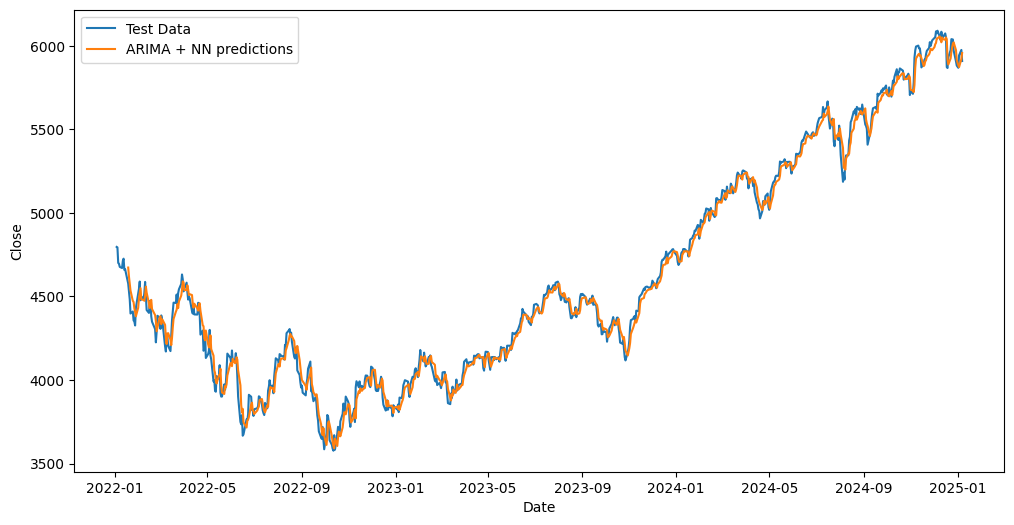

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


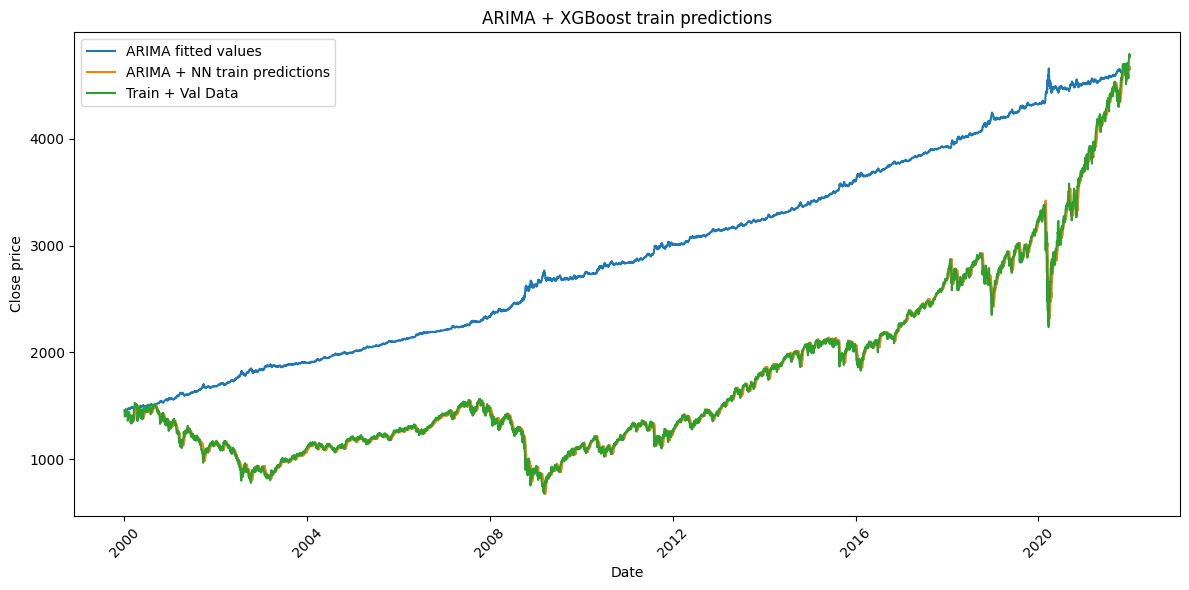

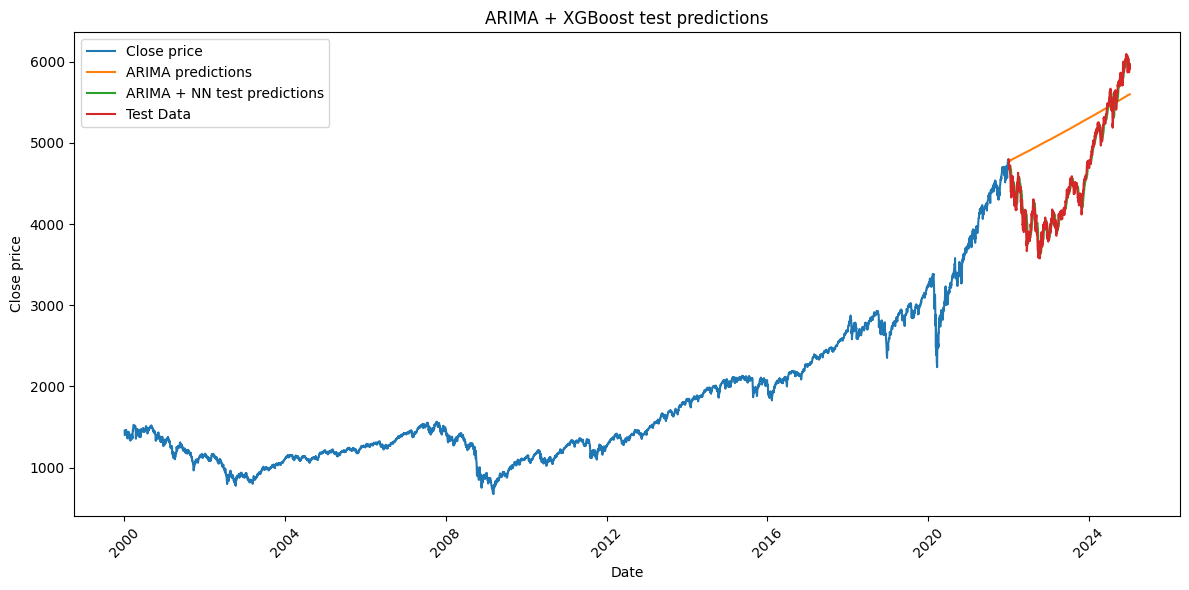

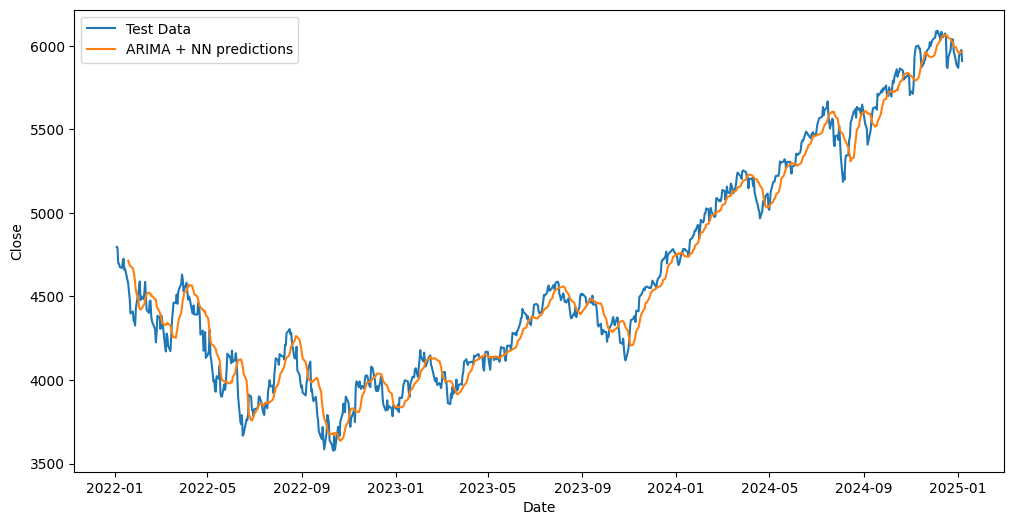

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
model_names = ['CNN', 'LSTM', 'parallelCNN_LSTM', 'LSTM_CNN'] #model names
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces
for model_name, model in zip(model_names, models):
    print(model)
    #generate predictions
    prediction, actual = inference(model, test_loader)
    train_predictions, actual_train = inference(model, train_val_loader)

    #rescale predictions
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(actual)
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)

    #set index
    prediction = pd.DataFrame(prediction)
    prediction.index = test_data[10:].index
    actual = pd.DataFrame(actual)
    actual.index = test_data[10:].index

    train_predictions = pd.DataFrame(train_predictions)
    train_predictions.index = train_val_data[10:].index
    actual_train = pd.DataFrame(actual_train)
    actual_train.index = train_val_data[10:].index

    #combine arima and NN predictions on test set
    ARIMA_NN_test_predictions = ARIMA_predictions[10:] + prediction[0]

    #combine arima and NN predictions on train set
    ARIMA_NN_train_predictions = fitted_values.iloc[10:,0].values + train_predictions[0]


    #visualize
    #predictions on train set
    plt.figure(figsize=(12, 6))
    # sns.lineplot(data = Close_price.loc[train_val_data.index], label="Close price")
    sns.lineplot(x=train_val_data.index, y=fitted_values.values.ravel(), label="ARIMA fitted values")
    # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
    sns.lineplot(x=train_val_data.index[10:], y=ARIMA_NN_train_predictions, label="ARIMA + NN train predictions")
    sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index ], label="Train + Val Data")
    plt.title('ARIMA + XGBoost train predictions')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #predictions on test set
    plt.figure(figsize=(12, 6))
    sns.lineplot(data = Close_price.loc[train_val_data.index], label="Close price")
    sns.lineplot(x=test_data.index, y=ARIMA_predictions.values.ravel(), label="ARIMA predictions")
    # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
    sns.lineplot(x=test_data.index[10:], y=ARIMA_NN_test_predictions, label="ARIMA + NN test predictions")
    sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
    plt.title('ARIMA + XGBoost test predictions')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()

    #close up
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
    sns.lineplot(x=test_data[10:].index, y=ARIMA_NN_test_predictions, label="ARIMA + NN predictions")
    plt.show()


    #save ARIMA + XGBoost predictions
    drive.mount('/content/gdrive')
    file_path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/CNN LSTM/ARIMA_{model_name}_predictions.csv'
    ARIMA_NN_test_predictions = pd.Series(ARIMA_NN_test_predictions, index=test_data.index)
    ARIMA_NN_test_predictions.to_csv(file_path, index=True)
